<a href="https://colab.research.google.com/github/lifesboy/selks-lstm-data/blob/main/SELKS_LSTM_Anomaly_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.LSTM KERAS

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

# 2.PREPARATION

In [1]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-01-18 05:23:24.311741: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 05:23:26.504389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-01-18 05:23:26.505608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-01-18 05:23:26.506697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [2]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import ray
import pyarrow
import pyarrow as pa
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input


import common
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string

run, client = common.init_experiment(name='notebook')


2023-01-18 05:23:29,437[INFO][140295818786624-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [ ]:
#@title Generate an input sequence
#10.0.2.10
#10.0.2.155
#10.0.2.180
#10.0.2.181
#10.0.2.182
#192.168.66.39
#192.168.66.21

cell_size = 256 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 128 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 65535   #@param {type:"integer"}

# generate datasets
train_size= 200 #@param {type:"integer"}
test_size = 50  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=100 #@param {type:"integer"}

L_fsource = '/cic/dataset/featured_extracted/ssh-bruteforce-forward-https-full/' #@param {type:"string"}
L_source = '/cic/dataset/normalized_labeled/ssh-bruteforce-forward-https-full/' #@param {type:"string"}
L_fdata: Dataset = read_csv_in_dir_label_string(L_fsource)
L_data: Dataset = read_csv_in_dir(L_source)
L_fcount: DataFrame = L_fdata.groupby(LABEL).aggregate(Count()).to_pandas()
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = [PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]
features = features[0: n_features]
Lfpadding_features = sorted(list(set(features) - set(L_fdata.schema(fetch_if_missing=True).names)))
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

print ('features=', features)
print ('Lfpadding_features=', Lfpadding_features)
print ('Lpadding_features=', Lpadding_features)

L_ftrain = DataFrame.from_records(L_fdata.take(train_size * n_timesteps_in)).fillna(0)
L_ftrain[Lfpadding_features] = 0
L_ftrain[LABEL] = L_ftrain.apply(lambda x: 'Anomaly' if x['src_ip'] == '172.18.12.113' else 'Benign', axis=1)
L_ftrain[LABEL] = L_ftrain[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
LX_ftrain = L_ftrain[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Ly_ftrain = L_ftrain[[LABEL]].to_numpy().reshape(train_size, n_timesteps_in)

L_ftest = DataFrame.from_records(L_fdata.take(test_size * n_timesteps_in)).fillna(0)
L_ftest[Lfpadding_features] = 0
L_ftest[LABEL] = L_ftest.apply(lambda x: 'Anomaly' if x['src_ip'] == '172.18.12.113' else 'Benign', axis=1)
L_ftest[LABEL] = L_ftest[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
LX_ftest = L_ftest[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Ly_ftest = L_ftest[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)

L_train = DataFrame.from_records(L_data.take(train_size * n_timesteps_in)).fillna(0)
L_train[Lpadding_features] = 0
L_train[LABEL] = L_ftrain[LABEL]
LX_train = L_train[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Ly_train = L_train[[LABEL]].to_numpy().reshape((train_size, n_timesteps_in))

L_test = DataFrame.from_records(L_data.take(test_size * n_timesteps_in)).fillna(0)
L_test[Lpadding_features] = 0
L_test[LABEL] = L_ftest[LABEL]
LX_test = L_test[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Ly_test = L_test[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)

Read progress:   1%|          | 1/125 [00:00<00:57,  2.17it/s]

In [ ]:
L_fcount

In [ ]:
L_count

## Data preview

### L_ftrain preview

In [ ]:
L_ftrain[[LABEL, *features]]

In [ ]:
L_ftrain[[LABEL, *features]].describe()

In [ ]:
DataFrame.from_records(LX_ftrain[0])

In [ ]:
DataFrame.from_records(LX_ftrain[0]).describe()

In [ ]:
DataFrame.from_records(Ly_ftrain)

In [ ]:
DataFrame.from_records(Ly_ftrain).describe()

### L_train preview

In [ ]:
L_train[[LABEL, *features]]

In [ ]:
L_train[[LABEL, *features]].describe()

In [ ]:
DataFrame.from_records(LX_train[0])

In [ ]:
DataFrame.from_records(LX_train[0]).describe()

In [ ]:
DataFrame.from_records(Ly_train)

In [ ]:
DataFrame.from_records(Ly_train).describe()

## Data visualization

In [ ]:
#@title create data IMG
IMG['LX_ftrain'], IMG['Ly_ftrain'], IMG['LX_ftest'], IMG['Ly_ftest'],\
IMG['LX_train'], IMG['Ly_train'], IMG['LX_test'], IMG['Ly_test'] = ray.get([
    show_scattered_4d.remote(LX_ftrain, 'LX_ftrain'),
    show_scattered_4d.remote(Ly_ftrain, 'Ly_ftrain'),
    show_scattered_4d.remote(LX_ftest, 'LX_ftest'),
    show_scattered_4d.remote(Ly_ftest, 'Ly_ftest'),
    
    show_scattered_4d.remote(LX_train, 'LX_train'),
    show_scattered_4d.remote(Ly_train, 'Ly_train'),
    show_scattered_4d.remote(LX_test, 'LX_test'),
    show_scattered_4d.remote(Ly_test, 'Ly_test'),
])

In [ ]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_ftrain','LX_train'])
show_4d_imgs(['Ly_ftrain','Ly_train'])
show_4d_imgs(['LX_ftest','LX_test'])
show_4d_imgs(['Ly_ftest','Ly_test'])

# 4.INTRODUCTION

To create powerful models, especially for solving Seq2Seq learning problems, LSTM is the key layer.
To use LSTM effectively in models, we need to understand how it generates different results with respect to given parameters.

## 4.1.QUICK RECAP OF LSTM

### 4.1.1.Internal Structure

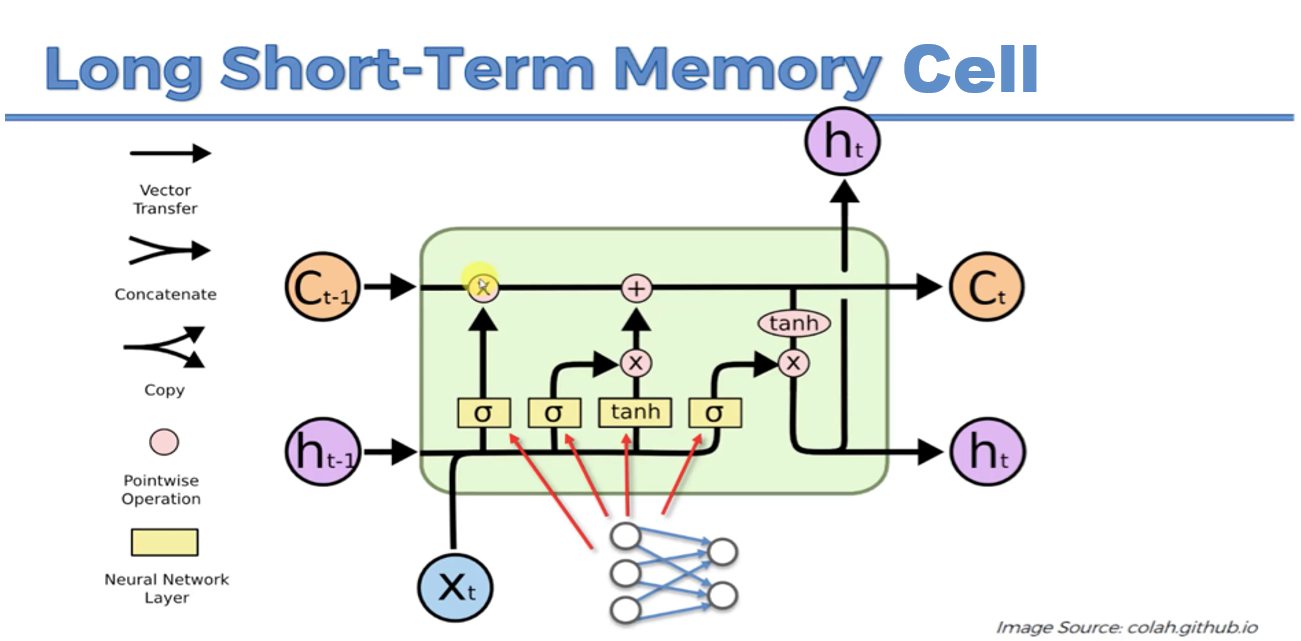

### 4.1.2.Roll-Out Representation of LSTM for each Time Step

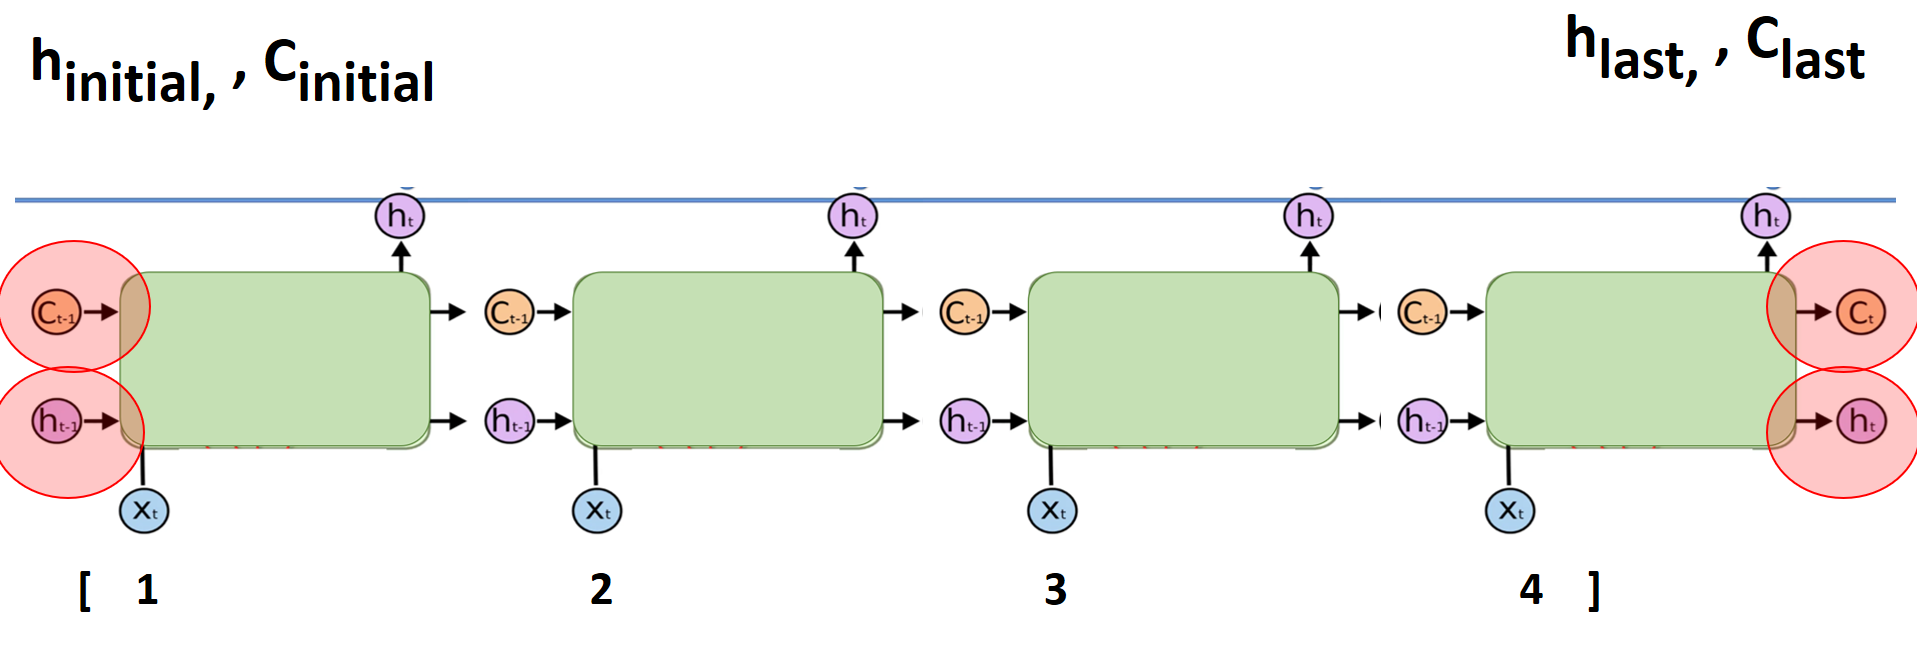

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [ ]:
def new_model5():
  num_outputs = 2
  # Define input layers
  input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
  state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
  state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
  #seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

  # Preprocess observation with a hidden layer and send to LSTM cell
  dense1 = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu, name="dense1")(input_layer)
  lstm_out, state_h, state_c = tf.keras.layers.LSTM(
      cell_size, return_sequences=True, return_state=True, name="lstm")(
      inputs=dense1,
      #mask=tf.sequence_mask(seq_in),
      initial_state=[state_in_h, state_in_c]
      )

  # Postprocess LSTM output with another hidden layer and compute values
  logits = tf.keras.layers.Dense(
      num_outputs,
      activation=tf.keras.activations.linear,
      name="logits")(lstm_out)
  values = tf.keras.layers.Dense(
      1, activation="sigmoid", name="values")(lstm_out)

  # Create the RNN model
  model5: Model = Model(
      inputs=
      [
        input_layer,
        #seq_in,
        state_in_h,
        state_in_c
      ],
      outputs=[logits, values, state_h, state_c])
  return model5

model5 = new_model5()
model5.summary()

h = np.zeros((train_size, cell_size), np.float32)
c = np.zeros((train_size, cell_size), np.float32)
IMG['h'], IMG['c'] = ray.get([
    show_scattered_4d.remote(h, "h"),
    show_scattered_4d.remote(c, "c"),
])

## 5.2.Train



In [ ]:
#@title state function

def train_state(model, x=LX_train, h=h, c=c, y=Ly_train, title=['model5', 'LX_train', 'h', 'c', 'Ly_train']):
  compile = model.predict([x, h, c])
  IMG[f"{title[4]}_predicted"], IMG[f"{title[4]}_h"], IMG[f"{title[4]}_c"] = ray.get([
    show_scattered_4d.remote(compile[1], f"{title[4]}_predicted"),
    show_scattered_4d.remote(compile[2], f"{title[4]}_h"),
    show_scattered_4d.remote(compile[3], f"{title[4]}_c"),
  ])

  show_4d_imgs([title[1], title[4], f"{title[4]}_predicted"])
  show_4d_imgs([title[1], title[2], f"{title[4]}_h"])
  show_4d_imgs([title[1], title[3], f"{title[4]}_c"])

In [ ]:
#@title train state

#model5.compile("adam", "binary_crossentropy", metrics=["accuracy"])
train_state(new_model5(), LX_train, h, c, Ly_train, ['model5', 'LX_train', 'h', 'c', 'Ly_train'])

In [ ]:
#@title train function

def train(model, name='model'):
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  history = model.fit(LX_train, Ly_train, batch_size=batch_size, epochs=epochs, validation_data=(LX_test, Ly_test))
  show_train_metric(history, name)


def ftrain(model, name='model'):
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  history = model.fit(LX_ftrain, Ly_ftrain, batch_size=batch_size, epochs=epochs, validation_data=(LX_ftest, Ly_ftest))
  show_train_metric(history, name)


In [ ]:
## 5.3.Infer

In [ ]:
#@title infer function

def infer(model):
  ##############LX_train
  L_result1=model.predict(LX_train)
  ##############LX_test
  L_result2=model.predict(LX_test)

  IMG['Ly_train_predicted'], IMG['Ly_test_predicted'] = ray.get([
    show_scattered_4d.remote(L_result1, "Ly_train_predicted"),
    show_scattered_4d.remote(L_result2, "Ly_test_predicted"),
  ])
  show_4d_imgs(['LX_train','Ly_train','Ly_train_predicted'])
  show_4d_imgs(['LX_test','Ly_test','Ly_test_predicted'])


def finfer(model):
  ##############LX_ftrain
  L_fresult1=model.predict(LX_ftrain)
  ##############LX_ftest
  L_fresult2=model.predict(LX_ftest)

  IMG['Ly_ftrain_predicted'], IMG['Ly_ftest_predicted'] = ray.get([
    show_scattered_4d.remote(L_fresult1, "Ly_ftrain_predicted"),
    show_scattered_4d.remote(L_fresult2, "Ly_ftest_predicted"),
  ])
  show_4d_imgs(['LX_ftrain','Ly_ftrain','Ly_ftrain_predicted'])
  show_4d_imgs(['LX_ftest','Ly_ftest','Ly_ftest_predicted'])


___

# 6.LSTM Anomaly model (Primary)

## 6.1.Model layers



In [ ]:
def new_model6():
  num_outputs = 10
  # Define input layers
  input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
  #state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
  #state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
  #seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

  # Preprocess observation with a hidden layer and send to LSTM cell
  #tf.nn.sigmoid
  dense1 = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu, name="dense1")(input_layer)
  lstm_out, state_h, state_c = tf.keras.layers.LSTM(
      cell_size, return_sequences=True, return_state=True, name="lstm")(
      inputs=dense1,
      #mask=tf.sequence_mask(seq_in),
      #initial_state=[state_in_h, state_in_c]
      )

  # Postprocess LSTM output with another hidden layer and compute values
  logits = tf.keras.layers.Dense(
      num_outputs,
      activation=tf.keras.activations.linear,
      name="logits")(lstm_out)
  values = tf.keras.layers.Dense(
      1, activation="sigmoid", name="values")(lstm_out)

  # Create the RNN model
  model6: Model = Model(
      inputs=input_layer,
      #[
      #  input_layer, #seq_in,
      #  state_in_h,
      #  state_in_c
      #],
      outputs=values
      #[
      #  logits,
      #  values,
      #  state_h,
      #  state_c
      #]
      )
  return model6

model6 = new_model6()
model6.summary()

## 6.2.Train



In [ ]:
train(model6, 'model6')
#ftrain(model6, 'model6')

## 6.3.Infer



In [ ]:
infer(model6)
#finfer(model6)

# 7.MODEL WEIGHTS SUMMARY

In [ ]:
weights5 = show_weights(model5, 'model5')
weights6 = show_weights(model6, 'model6')

show_4d_imgs(weights5)
show_4d_imgs(weights6)